# Random Forest for Board Game Success

Having tried to model the success of board games in my sample using a logistic regression, I found that the best results were obtained using an ensemble of logistic regression classifiers and taking a weighted majority vote. This naturally leads to trying out a random forest classifier, as it is another type of ensemble approach. This notebook will explore how the random forest will fare compared to the logistic regression.

## Simple Random Forest

Since we will be comparing to the logistic regression, let's start out simple. Just like with logistic regression, we will use the same cutoff point of 80th percentile for success, and try to predict without any attempt to balance the dataset. We can start by loading in the data and creating the same features and target as in the logistic regression notebook:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

with open('BGG_NoNaN_DF.pkl', 'rb') as f:
    noNaN_DF = pickle.load(f)

ratings = noNaN_DF['Rating']
target = ratings.apply(lambda x: x >= 5.84)
features = noNaN_DF.drop(['Rating', 'ID Num', 'User Number', 'Standard Dev'], axis=1)
print(target.shape, features.shape)

(17574,) (17574, 6)


Now we can just use an out of the box random forest classifier from sklearn:

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Split the data with a 70-30 train-test split, then do a grid search:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, 
                                                    test_size=0.3, random_state=42)
n_estimates = [150, 200, 250]
max_feats = [2, 3, 4]
max_depth = [1, 2, 3]
randfor = RandomForestClassifier(random_state=42)
clf_grid = GridSearchCV(randfor, {'n_estimators': n_estimates, 'max_features': max_feats, 'max_depth': max_depth}
                        , cv=5, scoring='accuracy')
clf_grid.fit(X_train, y_train)

# Predict on the test (and training) set to calculate metrics:
y_predict_train = clf_grid.predict(X_train)
y_predict_test = clf_grid.predict(X_test)

print('Best parameters for n_estimators, max_features, and max_depth: \n')
print(clf_grid.best_params_, clf_grid.best_score_)
print('\nAccuracy Score:')
print(accuracy_score(y_predict_test, y_test))
print('\nConfusion Matrix')
print(confusion_matrix(y_predict_test, y_test))

print("\n[Training Classification Report:]")
print(classification_report(y_train, y_predict_train))

print("[Test Classification Report:]")
print(classification_report(y_test, y_predict_test))

Best parameters for n_estimators, max_features, and max_depth: 

{'max_depth': 1, 'max_features': 2, 'n_estimators': 150} 0.7803430615397122

Accuracy Score:
0.7813388962639863

Confusion Matrix
[[4120 1153]
 [   0    0]]

[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.78      1.00      0.88      9599
       True       0.00      0.00      0.00      2702

avg / total       0.61      0.78      0.68     12301

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.78      1.00      0.88      4120
       True       0.00      0.00      0.00      1153

avg / total       0.61      0.78      0.69      5273



/Users/danielfeldman/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Just like with the logistic regression classifier, the random forest is experiencing the same problem typically seen with imbalanced datasets. That is, the majority class is swamping out the minority class, and so the classifier will just say everything is the majority class. As such, I think it'll be good to try to balance the dataset out in the ways similar to how I did it in the logistic regression notebook.

## Using SMOTE to create synthetic samples of the minority class

SMOTE is a good way to generate synthetic samples of the minority class by taking real samples and perturbing the values in the direction of the other real samples of the minority class. This can be used to make a balanced sample for classification. Last time, the best way I was able to achieve this was to use SMOTE to create samples **before** I did the train-test split, and then to proceed with classification. However, the downside to this method is that synthetic samples can bleed into the test set, so you're testing the classifier partially on fake data. Still, I'm going to try that first:

In [5]:
from imblearn.over_sampling import SMOTE

# Establish data set features and target:
X_before = features.values
y_before = target.values

# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_after, y_after = sm.fit_sample(X_before, y_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')

    # Do a train-test split of 70-30 on the new dataset:
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_after, y_after, 
                                                    test_size=0.3, random_state=42)
    
    # Train the random forest classifier using the same grid search as before:
    randfor = RandomForestClassifier(random_state=42)
    clf_smote = GridSearchCV(randfor, {'n_estimators': n_estimates, 'max_features': max_feats, 'max_depth': max_depth}
                            , cv=5, scoring='accuracy')
    clf_smote.fit(X_train_res, y_train_res)
    
    # Predict using best results then calculate the metrics:
    y_predict_train_res = clf_smote.predict(X_train_res)
    y_predict_test_res = clf_smote.predict(X_test_res)
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

SMOTE Algorithm: regular
--------------------------------------
Accuracy score: 0.6858600583090378

[[2936 1363]
 [1223 2710]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.69      0.70      0.69      9560
       True       0.70      0.68      0.69      9646

avg / total       0.69      0.69      0.69     19206

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.68      0.71      0.69      4159
       True       0.69      0.67      0.68      4073

avg / total       0.69      0.69      0.69      8232

SMOTE Algorithm: borderline1
--------------------------------------
Accuracy score: 0.6884110787172012

[[2951 1357]
 [1208 2716]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.67      0.70      0.69      9560
       True       0.69      0.66      0.67      9646

avg / total       0.68      0.68      0.68     19

In [6]:
print('Best parameters for n_estimators, max_features, and max_depth: \n')
print(clf_smote.best_params_, clf_smote.best_score_)

Best parameters for n_estimators, max_features, and max_depth: 

{'max_depth': 3, 'max_features': 2, 'n_estimators': 150} 0.7119129438717068


## Under-sampling the majority class--ensemble classifier

In the logistic regression notebook, the best results we obtained was via an ensemble classifier based on undersampling the majority class at random and taking a weighted majority vote. It's worth trying this out for the random forest algorithm and seeing if it gives similar (or better) results.

In [8]:
from sklearn.externals import joblib  # For pickling/unpickling models for saving

def accuracy_weighting(accuracy, vote):
    """
    Determines the vote of a classifier based on its accuracy and
    previous vote (0 or 1). If the vote was a 1, make it the 
    accuracy value instead. If a 0, do one minus the accuracy.
    """
    if vote:
        new_vote = accuracy
    else:
        new_vote = 1.0 - accuracy
    return new_vote

# First, let's separate out the different classes in the dataset:
target.name = 'Target'
noNaN_DF = pd.concat([noNaN_DF, target], axis=1)
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
trues_X = trues.drop(['ID Num', 'User Number', 'Rating', 'Target'], axis=1)
falses_y = falses['Target']
falses_X = falses.drop(['ID Num', 'User Number', 'Rating', 'Target'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))

# Given the number of classifiers I'm building, will need a smaller grid to search:
max_depth_rand = [1, 2, 3]

# Now to initialize relevant path and lists:
PKLPATH = 'pkl_files/'
models = []
votes = []

# Build & train classifiers, then have them vote, saving results along the way:
for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    randfor_rand = RandomForestClassifier(max_features=2, n_estimators=200, random_state=j, oob_score=True)
    clf_rand = GridSearchCV(randfor, {'max_depth': max_depth_rand}, cv=5, scoring='accuracy')
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    accuracy = accuracy_score(prediction, y_test_folds)
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}rand_forest_ens{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}rand_forest_ens{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

In [9]:
# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.6924608819345661

Confusion Matrix: 

[[1863  200]
 [ 881  571]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.90      0.68      0.78      2744
       True       0.39      0.74      0.51       771

avg / total       0.79      0.69      0.72      3515



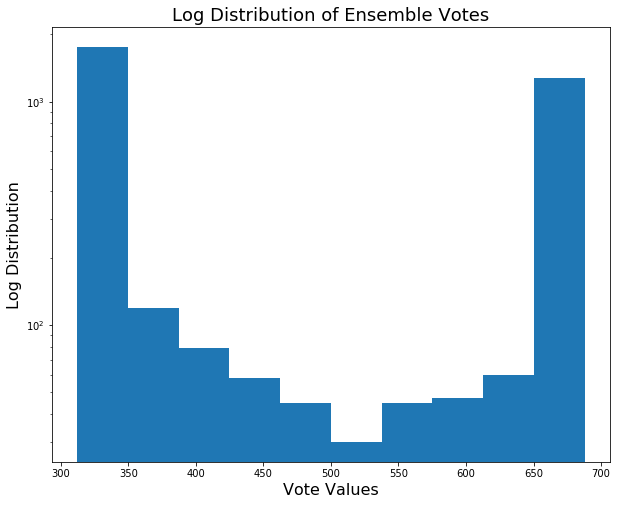

In [10]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

What about using the OOB score instead of accuracy to score the individual classifiers? Let's try it:

In [11]:
# Now to initialize relevant path and lists:
PKLPATH = 'pkl_files/'
models = []
votes = []

# Build & train classifiers, then have them vote, saving results along the way:
for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    clf_rand = RandomForestClassifier(max_features=2, n_estimators=200, random_state=j, 
                                          oob_score=True, max_depth=3)
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    #accuracy = accuracy_score(prediction, y_test_folds)
    acccuracy = clf_rand.oob_score_
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}rand_forest_ens_oob_noUN{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}rand_forest_ens_oob_noUN{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.7027027027027027

Confusion Matrix: 

[[1871  172]
 [ 873  599]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.92      0.68      0.78      2744
       True       0.41      0.78      0.53       771

avg / total       0.80      0.70      0.73      3515



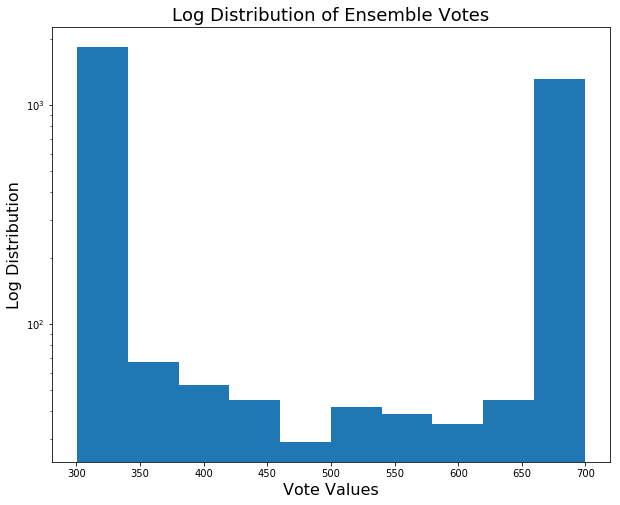

In [12]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

Last thing to try: I am using the standard deviation of votes in the model, which is potentially problematic. What if I got rid of it as a feature? Let's try that and see if we significantly lose out on accuracy:

In [13]:
# First, let's separate out the different classes in the dataset:
noNaN_DF = noNaN_DF.drop(['Target'], axis=1)
target.name = 'Target'
noNaN_DF = pd.concat([noNaN_DF, target], axis=1)
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
falses_y = falses['Target']
trues_X = trues.drop(['Standard Dev', 'ID Num', 'User Number', 'Rating', 'Target'], axis=1)
falses_X = falses.drop(['Standard Dev', 'ID Num', 'User Number', 'Rating', 'Target'], axis=1)

In [14]:
# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))

# Now to initialize relevant path and lists:
PKLPATH = 'pkl_files/'
models = []
votes = []

# Build & train classifiers, then have them vote, saving results along the way:
for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    clf_rand = RandomForestClassifier(max_features=2, n_estimators=200, random_state=j, 
                                          oob_score=True, max_depth=3)
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    #accuracy = accuracy_score(prediction, y_test_folds)
    acccuracy = clf_rand.oob_score_
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}rand_forest_ens_oob_nostd{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}rand_forest_ens_oob_nostd{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.6938833570412518

Confusion Matrix: 

[[1926  258]
 [ 818  513]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.70      0.78      2744
       True       0.39      0.67      0.49       771

avg / total       0.77      0.69      0.72      3515



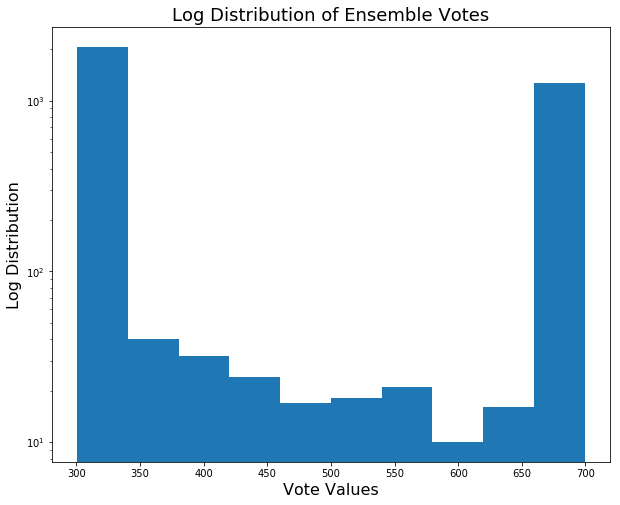

In [15]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

In [35]:
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
trues_X = trues.drop(['ID Num', 'Rating', 'Target'], axis=1)
falses_y = falses['Target']
falses_X = falses.drop(['ID Num', 'Rating', 'Target'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))

# Now to initialize relevant path and lists:
PKLPATH = 'pkl_files/'
models = []
votes = []

# Build & train classifiers, then have them vote, saving results along the way:
for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    clf_rand = RandomForestClassifier(max_features=2, n_estimators=200, random_state=j, 
                                          oob_score=True, max_depth=3)
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    #accuracy = accuracy_score(prediction, y_test_folds)
    acccuracy = clf_rand.oob_score_
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}rand_forest_ens_oob{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}rand_forest_ens_oob{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.8990252436890778

Confusion Matrix: 

[[2812   22]
 [ 382  785]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.99      0.88      0.93      3194
       True       0.67      0.97      0.80       807

avg / total       0.93      0.90      0.91      4001



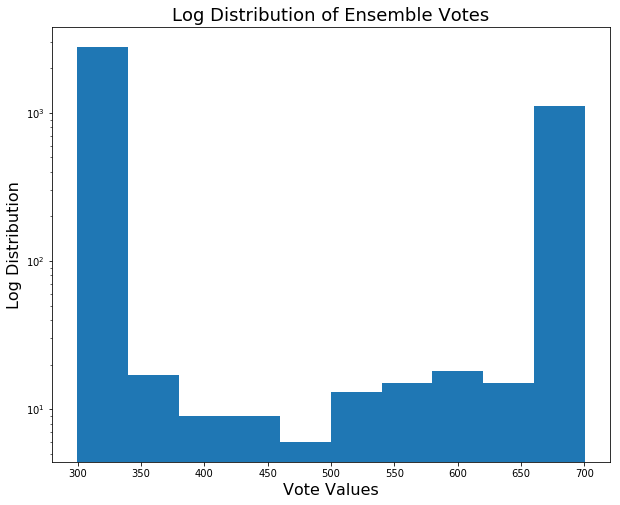

In [36]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

## Redoing SMOTE for fewer features

In [16]:
ratings = noNaN_DF['Rating']
target = ratings.apply(lambda x: x >= 5.84)
features = noNaN_DF.drop(['Standard Dev', 'ID Num', 'User Number', 'Rating', 'Target'], axis=1)
print(features.columns)

Index(['Weight', 'Min Playtime', 'Max Playtime', 'Year Published', 'Min Players', 'Max Players'], dtype='object')


In [17]:
# Establish data set features and target:
X_before = features.values
y_before = target.values

# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_after, y_after = sm.fit_sample(X_before, y_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')

    # Do a train-test split of 70-30 on the new dataset:
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_after, y_after, 
                                                    test_size=0.3, random_state=42)
    
    # Train the random forest classifier using the same grid search as before:
    randfor = RandomForestClassifier(random_state=42)
    clf_smote = GridSearchCV(randfor, {'n_estimators': n_estimates, 'max_features': max_feats, 'max_depth': max_depth}
                            , cv=5, scoring='accuracy')
    clf_smote.fit(X_train_res, y_train_res)
    
    # Predict using best results then calculate the metrics:
    y_predict_train_res = clf_smote.predict(X_train_res)
    y_predict_test_res = clf_smote.predict(X_test_res)
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

SMOTE Algorithm: regular
--------------------------------------
Accuracy score: 0.6858600583090378

[[2936 1363]
 [1223 2710]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.69      0.70      0.69      9560
       True       0.70      0.68      0.69      9646

avg / total       0.69      0.69      0.69     19206

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.68      0.71      0.69      4159
       True       0.69      0.67      0.68      4073

avg / total       0.69      0.69      0.69      8232

SMOTE Algorithm: borderline1
--------------------------------------
Accuracy score: 0.6884110787172012

[[2951 1357]
 [1208 2716]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.67      0.70      0.69      9560
       True       0.69      0.66      0.67      9646

avg / total       0.68      0.68      0.68     19

In [18]:
print('Best parameters for n_estimators, max_features, and max_depth: \n')
print(clf_smote.best_params_, clf_smote.best_score_)

Best parameters for n_estimators, max_features, and max_depth: 

{'max_depth': 3, 'max_features': 2, 'n_estimators': 150} 0.7119129438717068


In [19]:
# Establish data set features and target:
X_before = features.values
y_before = target.values
print(X_before.shape, y_before.shape)
# Do a train-test split of 70-30 on the new dataset:
X_train_before, X_test_res, y_train_before, y_test_res = train_test_split(X_before, y_before, 
                                                test_size=0.3, random_state=42)
print(X_train_before.shape, X_test_res.shape)
# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_train_res, y_train_res = sm.fit_sample(X_train_before, y_train_before)
    print(X_train_res.shape)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')
    
    # Train the random forest classifier using the same grid search as before:
    randfor = RandomForestClassifier(random_state=42)
    clf_smote = GridSearchCV(randfor, {'n_estimators': n_estimates, 'max_features': max_feats, 'max_depth': max_depth}
                            , cv=5, scoring='accuracy')
    clf_smote.fit(X_train_res, y_train_res)
    
    # Predict using best results then calculate the metrics:
    y_predict_train_res = clf_smote.predict(X_train_res)
    y_predict_test_res = clf_smote.predict(X_test_res)
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(17574, 6) (17574,)
(12301, 6) (5273, 6)
(19198, 6)
SMOTE Algorithm: regular
--------------------------------------
Accuracy score: 0.6887919590366015

[[2888  409]
 [1232  744]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.69      0.70      0.70      9599
       True       0.70      0.68      0.69      9599

avg / total       0.69      0.69      0.69     19198

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.70      0.78      4120
       True       0.38      0.65      0.48      1153

avg / total       0.77      0.69      0.71      5273

(19198, 6)
SMOTE Algorithm: borderline1
--------------------------------------
Accuracy score: 0.6853783424995259

[[2866  405]
 [1254  748]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.68      0.70      0.69      9599
       True       0.69      0.67      0.

In [46]:
# Get the ratings for the test set used in the last SMOTE algorithm:
_, X_test_res, __, y_test_rate = train_test_split(X_before, ratings.values, 
                                                test_size=0.3, random_state=42)

print(y_predict_test_res)
test_true_ind = np.where(y_predict_test_res==True)[0]
print(test_true_ind)
ratings_true = y_test_rate[test_true_ind]

[False False  True ...  True  True  True]
[   2    4    8 ... 5997 5998 5999]


In [47]:
print(ratings_true.max(), ratings_true.min())

8.10634 5.26241


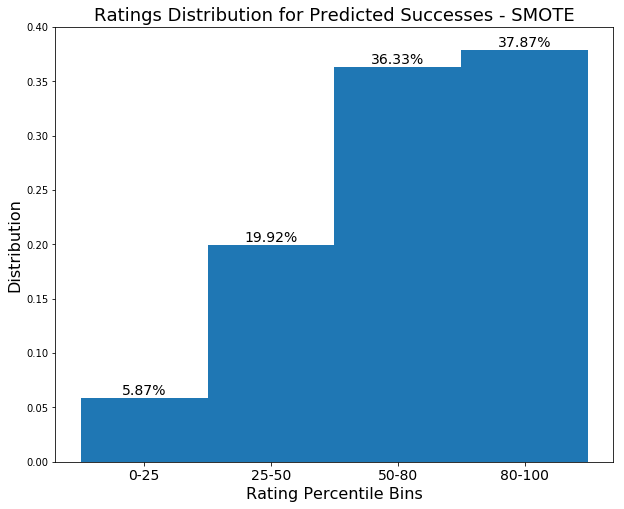

In [49]:
hist = np.histogram(ratings_true, bins=(5,5.524,5.581,5.84,8.2))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
#_ = axes.hist(ratings_true_pred, bins=[5,5.524,5.581,5.84,8.1])
rects = axes.bar(range(4), percents, width=1)
xticks = ['0-25', '25-50', '50-80', '80-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.4])
_ = plt.title('Ratings Distribution for Predicted Successes - SMOTE', fontsize=18)
plt.show()

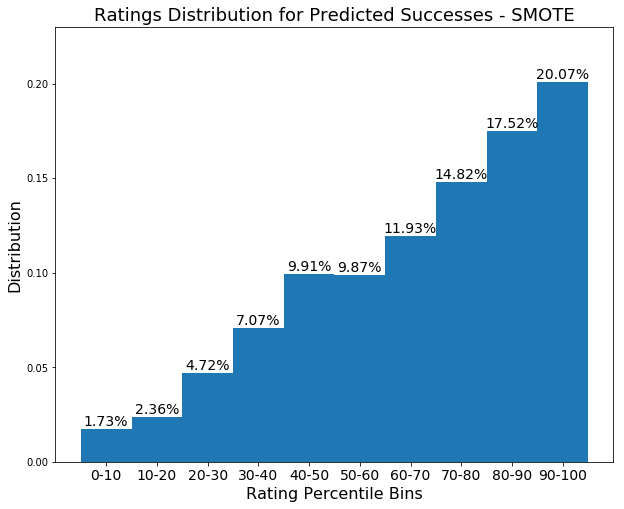

In [53]:
hist = np.histogram(ratings_true, bins=(np.percentile(noNaN_DF.Rating, 0),np.percentile(noNaN_DF.Rating, 10),
                                   np.percentile(noNaN_DF.Rating, 20),np.percentile(noNaN_DF.Rating, 30),
                                   np.percentile(noNaN_DF.Rating, 40),np.percentile(noNaN_DF.Rating, 50),
                                   np.percentile(noNaN_DF.Rating, 60),np.percentile(noNaN_DF.Rating, 70),
                                   np.percentile(noNaN_DF.Rating, 80),np.percentile(noNaN_DF.Rating, 90),
                                   np.percentile(noNaN_DF.Rating, 100)))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
#_ = axes.hist(ratings_true_pred, bins=[5,5.524,5.581,5.84,8.1])
rects = axes.bar(range(0,40,4), percents, width=4)
xticks = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80',
          '80-90', '90-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,40,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.23])
_ = plt.title('Ratings Distribution for Predicted Successes - SMOTE', fontsize=18)
plt.show()